In [1]:
import torch
from dataset.cambridge import CambridgeDataset
from dataset.seven_scenes import SevenScenesDataset
from option.nerf_option import NeRFOption
from model.nerfw_system import NeRFWSystem         # old
# from model.nerfw_system_updated import NeRFWSystem # latest
import torch.multiprocessing as mp
import torch.distributed as dist
from torch.nn.parallel import DistributedDataParallel as DDP
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm
import numpy as np
import cv2
import pickle

In [2]:

opt_path='./runs/nerf/church/opt.pkl'
with open(opt_path,mode='rb') as f:
    opt=pickle.load(f)
    # opt.data_root_dir='G:\\dataset\\Cambridge' # 自定义data_root_dir
# train_dataset = CambridgeDataset(opt.data_root_dir, opt.scene, split='train', img_downscale=3, use_cache=False,if_save_cache=True)
valid_dataset = CambridgeDataset(opt.data_root_dir, opt.scene, split='valid', img_downscale=3, use_cache=True)


load reconstruction data of scene "StMarysChurch", split: valid
cache load done...


In [3]:
nerf = NeRFWSystem(valid_dataset.N_views, 128, 256, opt.use_disp,opt.perturb, opt.layers, opt.W, opt.N_xyz_freq, 
                   opt.N_dir_freq, opt.encode_a, opt.encode_t,opt.a_dim, opt.t_dim, beta_min=opt.beta_min,
                     lambda_u=opt.lambda_u)
ckpt_path='G:\\projects\\python\\nerfw-pytorch\\runs\\nerf\\church\\ckpt_epoch14_iter5226_psnr-17.383c-17.786f.pkl'
ckpt=torch.load(ckpt_path) # load ckpt
nerf.load_state_dict(ckpt['nerf'])
nerf = nerf.cuda()

In [4]:
import torchvision.transforms as T
def visualize_depth(depth, cmap=cv2.COLORMAP_JET):
    """
    depth: (H, W)
    """
    x = depth.cpu().numpy()
    x = np.nan_to_num(x) # change nan to 0
    mi = np.min(x) # get minimum depth
    ma = np.max(x)
    x = (x-mi)/(ma-mi+1e-8) # normalize to 0~1
    x = (255*x).astype(np.uint8)
    heat_img=cv2.applyColorMap(x,colormap=cmap)
    return heat_img

i: 1160


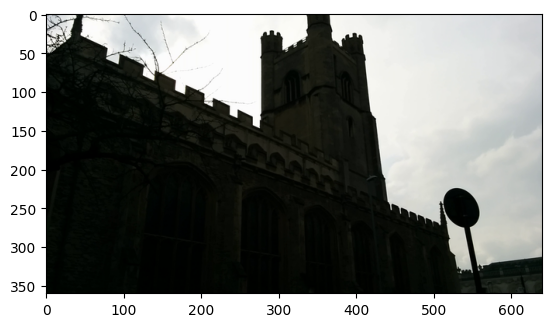

In [5]:
# get rays and show img
import matplotlib.pyplot as plt
import random
w,h=valid_dataset.downscale_size
# file_name='seq1/frame00002.png'
# file_id=valid_dataset.file2id[file_name]
# idx=valid_dataset.train_set.index(file_id)

i=random.randint(0, len(valid_dataset.train_set)-1)
print('i:',i)
# test_id=valid_dataset.test_set[random.randint(0,len(valid_dataset.test_set)-1)]
all_rays = valid_dataset.__getitem__(idx=i)
# all_rays = valid_dataset.get_rays(i=test_id)
all_rays = all_rays.cuda()  # 在GPU:0上推理
y_img = all_rays[:, 9:].view(h, w, 3)  # GT
y_img_np = (y_img.cpu().numpy()*255).astype(np.uint8) # [0,1]
plt.imshow(y_img_np)
plt.show()

In [6]:
from utils.evaluation_metrics import psnr
import time
import os
# valid: inference
chunk=1024
ti=time.time()
with torch.no_grad():
    res= nerf.inference(all_rays[:,:9], chunk)
    cc, fc,z=res['cc'],res['fc'],res['z']
    if nerf.encode_t:
        fs, ft=res['fs'],res['ft']
print('cost %.3fs'%(time.time()-ti))
w,h=valid_dataset.downscale_size
cc = cc.view(h, w, 3)  # coarse img
fs= fs.view(h, w, 3)  # static img
ft = ft.view(h, w, 3)  # transient img
fc = fc.view(h, w, 3)  # fine img = static + transient
z=z.view(h, w, 1)  # depth

psnr_c, psnr_f = psnr(cc, y_img), psnr(fc, y_img) # psnr of coarse and fine img
print('coarse psnr: %.3f, fine psnr: %.3f' % (psnr_c, psnr_f))


cost 115.824s
coarse psnr: 22.496, fine psnr: 25.504


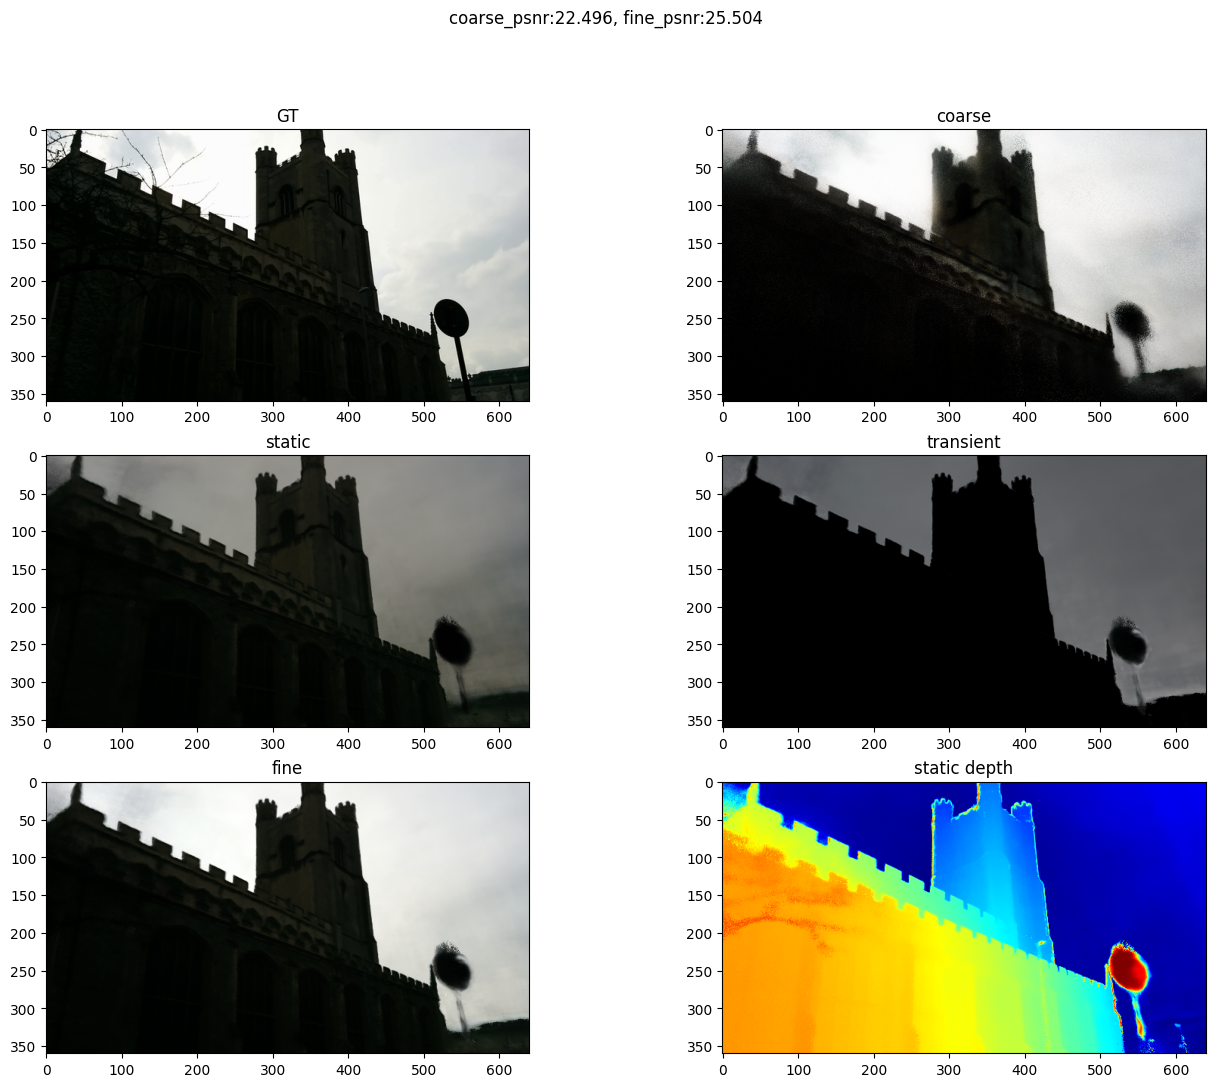

In [7]:
# show the result of the model
c_img = (np.clip(cc.cpu().numpy(),0,1) * 255).astype(np.uint8)
fs_img = (np.clip(fs.cpu().numpy(),0,1) * 255).astype(np.uint8)
ft_img = (np.clip(ft.cpu().numpy(),0,1) * 255).astype(np.uint8)
f_img = (np.clip(fc.cpu().numpy(),0,1) * 255).astype(np.uint8)
# y_img_np=cv2.cvtColor(y_img_np,cv2.COLOR_RGB2BGR)
# show img in the save plt window
plt.figure(figsize=(16, 12))
plt.subplot(3, 2, 1), plt.imshow(y_img_np), plt.title('GT')
plt.subplot(3, 2, 2), plt.imshow(c_img), plt.title('coarse')
plt.subplot(3, 2, 3), plt.imshow(fs_img), plt.title('static')
plt.subplot(3, 2, 4), plt.imshow(ft_img), plt.title('transient')
plt.subplot(3, 2, 5), plt.imshow(f_img), plt.title('fine')
plt.subplot(3, 2, 6), plt.imshow(visualize_depth(z)), plt.title('static depth')
plt.suptitle('coarse_psnr:%.3f, fine_psnr:%.3f' % (psnr_c, psnr_f))
plt.savefig('./inference.png')
# save
# cv2.imwrite('imgs/coarse.png', cv2.cvtColor(c_img, cv2.COLOR_RGB2BGR))
# cv2.imwrite('imgs/static.png', cv2.cvtColor(fs_img, cv2.COLOR_RGB2BGR))
# cv2.imwrite('imgs/transient.png', cv2.cvtColor(ft_img, cv2.COLOR_RGB2BGR))
# cv2.imwrite('imgs/fine.png', cv2.cvtColor(f_img, cv2.COLOR_RGB2BGR))
# cv2.imwrite('imgs/GT.png', cv2.cvtColor(y_img_np, cv2.COLOR_RGB2BGR))

In [ ]:
# 计算所有train_set
import matplotlib.pyplot as plt
import random
from utils.evaluation_metrics import psnr
import time
for i in range(len(valid_dataset.train_set)):

    all_rays = valid_dataset.__getitem__(idx=i)
    id=valid_dataset.train_set[i]
    print('i:%d id:%d file_name:%s'%(i,id,valid_dataset.view_filename[id]))
    all_rays = all_rays.cuda()  # 在GPU:0上推理
    y_img = all_rays[:, 9:].view(360, 640, 3)  # GT
    y_img_np = y_img.cpu().numpy() # [0,1]

    # valid: inference
    chunk=6*1024
    ti=time.time()
    with torch.no_grad():
        cc, fs, ft, fc,z= nerf.inference(all_rays[:,:9], chunk)
    print('cost %.3fs'%(time.time()-ti))
    w,h=valid_dataset.downscale_size
    cc = cc.view(h, w, 3)  # coarse img
    fs= fs.view(h, w, 3)  # static img
    ft = ft.view(h, w, 3)  # transient img
    fc = fc.view(h, w, 3)  # fine img = static + transient
    z=z.view(h, w, 1)  # depth

    psnr_c, psnr_f = psnr(cc, y_img), psnr(fc, y_img) # psnr of coarse and fine img
    print('coarse psnr: %.3f, fine psnr: %.3f' % (psnr_c, psnr_f))

    # show the result of the model
    c_img = np.clip(cc.cpu().numpy(),0,1) * 255
    fs_img = np.clip(fs.cpu().numpy(),0,1) * 255
    ft_img = np.clip(ft.cpu().numpy(),0,1) * 255
    f_img = np.clip(fc.cpu().numpy(),0,1) * 255
    # 转int8
    c_img = c_img.astype(np.uint8)
    fs_img = fs_img.astype(np.uint8)
    ft_img = ft_img.astype(np.uint8)
    f_img = f_img.astype(np.uint8)
    # y_img_np=cv2.cvtColor(y_img_np,cv2.COLOR_RGB2BGR)
    # show img in the save plt window
    plt.figure(figsize=(16, 12)),plt.subplot(3, 2, 1),plt.imshow(y_img_np),plt.title('GT')
    plt.subplot(3,2, 2),plt.imshow(c_img),plt.title('coarse'),plt.subplot(3, 2, 3),plt.imshow(fs_img),
    plt.title('static'),plt.subplot(3, 2, 4),plt.imshow(ft_img),plt.title('transient'),plt.subplot(3, 2, 5)
    plt.imshow(f_img),plt.title('fine'),plt.subplot(3,2,6),plt.imshow(visualize_depth(z)),plt.title('static depth')
    plt.suptitle('coarse_psnr:%.3f, fine_psnr:%.3f'%(psnr_c,psnr_f))
    plt.savefig(f'imgs/Figure{i}_finePSNR{psnr_f}.png')
    plt.show()

